In [25]:
### Part 1.1: Convolve x and y. ###
import numpy as np
import skimage as sk
import skimage.io as skio
from scipy import signal

# name of the input file
imname = 'cameraman.png'

# read in the image
im = skio.imread(imname, as_gray=True)

# convert to double (might want to do this later on to save memory)    
grey_im = sk.img_as_float(im)

def derivative(im):
    # dx, dy partial filters.
    dx_1 = [[1, -1]]
    dy_1 = [[1], [-1]]

    # convolved images.
    x_filtered = signal.convolve2d(im, dx_1, mode="same")
    y_filtered = signal.convolve2d(im, dy_1, mode="same")

    #binarizing an image
    lower, upper = -0.1, 0.1
    edge_x = ((x_filtered < lower) | (x_filtered > upper)).astype(int)
    edge_y = ((y_filtered < lower) | (y_filtered > upper)).astype(int)
    
    print(edge_x)
    skio.imsave('results/pt1_edge_x.jpg', edge_x)
    skio.imsave('results/pt1_edge_y.jpg', edge_y)

derivative(grey_im)

/Users/brianliu/opt/miniconda3/envs/tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: results/pt1_edge_x.jpg is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/brianliu/opt/miniconda3/envs/tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: results/pt1_edge_y.jpg is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 1 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


In [28]:
### Part 1.2: the DoG Filters.
import cv2
def apply_dog(grey_im):
    gaussian = cv2.getGaussianKernel(5, 0)
    gaussian = gaussian * np.transpose(gaussian)
    # dx, dy partial filters.
    dx_1 = [[1, -1]]
    dy_1 = [[1], [-1]]
    
    DoG_x = signal.convolve2d(gaussian, dx_1)
    DoG_y = signal.convolve2d(gaussian, dy_1)

    # convolved images.
    x_edges = signal.convolve2d(grey_im, DoG_x, mode="same")
    y_edges = signal.convolve2d(grey_im, DoG_y, mode="same")
    
    return x_edges, y_edges

x_edges, y_edges = apply_dog(grey_im)
lower, upper = -0.1, 0.1
# Thresholding image -> binary image.
x_edges = ((x_edges < lower) | (x_edges > upper)).astype(int)
y_edges = ((y_edges < lower) | (y_edges > upper)).astype(int)

skio.imsave('results/pt2_edge_x.jpg', x_edges)
skio.imsave('results/pt2_edge_y.jpg', y_edges)
combo = x_edges + y_edges
skio.imsave('results/pt2_edgecombo.jpg', combo)


/Users/brianliu/opt/miniconda3/envs/tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: results/pt2_edge_x.jpg is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/brianliu/opt/miniconda3/envs/tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: results/pt2_edge_y.jpg is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/brianliu/opt/miniconda3/envs/tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: results/pt2_edgecombo.jpg is a low contrast image
Lossy conversion from int64 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.


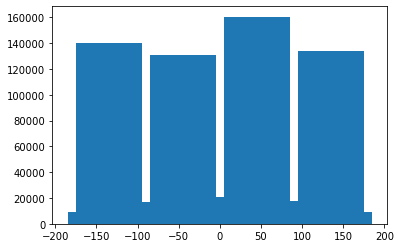

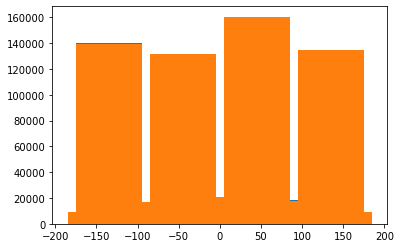

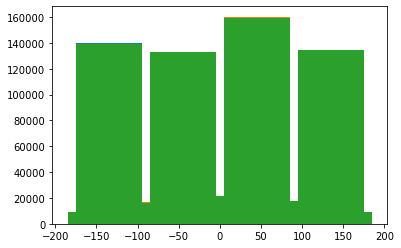

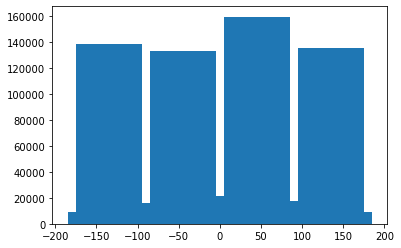

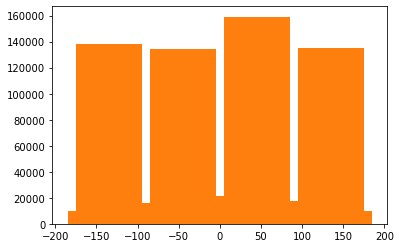

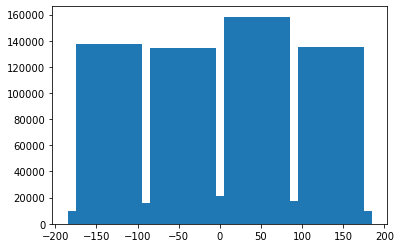

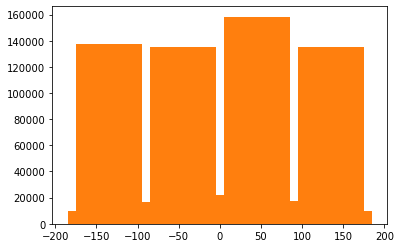

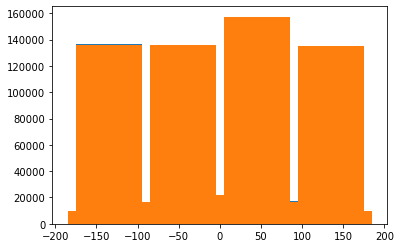

13


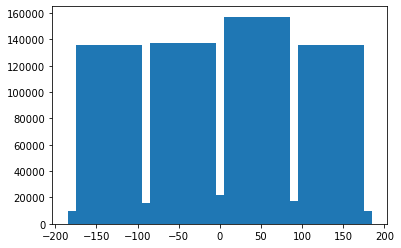

In [73]:
# Part 1.3 aligning an image. 
from scipy import ndimage
import matplotlib.pyplot as plt
import math
# name of the input file
imname = 'mountains.png'

# read in the image
im = skio.imread(imname, as_gray=True)
im = sk.img_as_float(im)

right_angles = [-180, -90, 0, 90, 180]
uncertainty = 5
bins = []
for angle in right_angles:
    bins.append(angle - uncertainty)
    bins.append(angle + uncertainty)


    
max_aligned = 0
best_rotated = None
best_angle = None

# Brute force searach through all possible rotation angles.
for i in range(0, 15):
    
    rotated = ndimage.interpolation.rotate(im, -i)
    w, l = rotated.shape
    #Take middle part of image
    cropped = rotated[w//2-400:w//2+400, l//2-400:l//2+400]
    #Find derivatives of x and y. I used DoG to denoise.
    x, y = apply_dog(cropped)
    
    #If needed, threshold the image. I found that it affected my histograms, so I took it out.
    #grad_mag = np.sqrt(np.square(x) + np.square(y))
    #x[grad_mag < 0.05 * grad_mag.max()] = 0
    #y[grad_mag < 0.05 * grad_mag.max()] = 0
    
    #Create the histogram.
    res = plt.hist(np.degrees(np.arctan2(-y, x).flatten()), bins)
    
    sm = 0
    #I've configured it such that every other bin contains a right angle. So we sum up the total number of right angles.
    for j in range(len(res[0])):
        if j % 2 == 0:
            sm += res[0][j]
    
    if sm > max_aligned:
        max_aligned = sm
        best_rotated = rotated
        best_angle = i
        plt.show()
        
print(best_angle)
im = skio.imread(imname)
skio.imsave('results/pt3_mountains.jpg', ndimage.interpolation.rotate(im, -best_angle)[:,:,:3])

In [88]:
# Part 2.1 sharpening an image. 

# name of the input file
imname = 'bird.jpg'

# read in the image
im = skio.imread(imname)
im = sk.img_as_float(im)

# show original
skio.imsave('results/og_bird2.jpg', im)

r, g, b = im[:,:,0], im[:,:,1], im[:,:,2]

a = 5
gaussian = cv2.getGaussianKernel(15, 0)
gaussian = gaussian * np.transpose(gaussian)

# make it blurry first. 
r = signal.convolve2d(r, gaussian, mode="same")
g = signal.convolve2d(g, gaussian, mode="same")
b = signal.convolve2d(b, gaussian, mode="same")
skio.imsave('results/blurred_bird2.jpg', np.dstack((r, g, b)))

unit_impulse = (1 + a) * signal.unit_impulse((15, 15), "mid")
laplacian_gaussian = unit_impulse - a * gaussian

im_r = np.clip(signal.convolve2d(r, laplacian_gaussian, mode="same"), 0, 1)
im_g = np.clip(signal.convolve2d(g, laplacian_gaussian, mode="same"), 0, 1)
im_b = np.clip(signal.convolve2d(b, laplacian_gaussian, mode="same"), 0, 1)

skio.imsave('results/pt4_shap_blur_bird2.jpg', np.dstack((im_r, im_g, im_b)))

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [124]:
# Part 2.2 hybrid image code is contained within hybrid_images/hybriad_image_starter.py

In [117]:
# part 2.3 gaussian & laplacian stacks. 
im = skio.imread("results/trump_biden.jpg", as_gray=True)
N = 5
def gaussian_stack(im):
    n = N
    g = cv2.getGaussianKernel(35, 10) * np.transpose(cv2.getGaussianKernel(35, 10))
    stack = [im]
    while n:
        im = signal.convolve2d(im, g, mode="same")
        stack.append(im)
        n -= 1
    return stack

def laplacian_stack(gaus_stack):
    stack = [gaus_stack[0]]
    for i in range(1, N):
        stack.append(gaus_stack[i-1] - gaus_stack[i])
    return stack

g_stck = gaussian_stack(im)
l_stck = laplacian_stack(g_stck)

#for i in range(len(l_stck)):
 #   skio.imsave("stack2/l_stck " + str(i) + ".jpg", l_stck[i])
    
#for i in range(len(g_stck)):
 #   skio.imsave("stack2/g_stck " + str(i) + ".jpg", g_stck[i])


In [123]:
# part 2.4: multiresolution blending. 
iml = skio.imread("jazz.jpeg", as_gray=True)
imr = skio.imread("milky.jpg", as_gray=True)

mask = skio.imread("jazz_mask.jpg", as_gray=True)

def match_img_size(im1, im2):
    # Make images the same size
    h1, w1 = im1.shape
    h2, w2 = im2.shape
    if h1 < h2:
        im2 = im2[int(np.floor((h2-h1)/2.)) : -int(np.ceil((h2-h1)/2.)), :]
    elif h1 > h2:
        im1 = im1[int(np.floor((h1-h2)/2.)) : -int(np.ceil((h1-h2)/2.)), :]
    if w1 < w2:
        im2 = im2[:, int(np.floor((w2-w1)/2.)) : -int(np.ceil((w2-w1)/2.))]
    elif w1 > w2:
        im1 = im1[:, int(np.floor((w1-w2)/2.)) : -int(np.ceil((w1-w2)/2.))]
    assert im1.shape == im2.shape
    return im1, im2


mask = mask/mask.max()


def blend(iml, imr, mask):
    iml, imr = match_img_size(iml, imr)
    iml, mask = match_img_size(iml, mask)
    
    G = gaussian_stack(mask)
    imlg = gaussian_stack(iml)
    imrg = gaussian_stack(imr)
    LX = laplacian_stack(imlg)
    LY = laplacian_stack(imrg)
    LS = []
    for i in range(N):
        l1 = np.multiply(G[i], LX[i])
        #skio.imsave('l'+str(i)+'.jpg', l1)

        l2 = np.multiply(1-G[i], LY[i])
        #skio.imsave('r'+str(i)+'.jpg', l2)
        layer = l1 + l2
        LS.append(layer)

    # To restore original, we need to add back last layer of the Gaussian. 
    LS.append(imlg[N] + imrg[N])

    return sum(LS)


#rl, gl, bl = iml[:,:,0], iml[:,:,1], iml[:,:,2]
#rr, gr, br = imr[:,:,0], imr[:,:,1], imr[:,:,2]

#rs, gs, bs = blend(rl, rr, mask), blend(gl, gr, mask), blend(bl, br, mask)
#skio.imsave("pinkbrian.jpg", np.dstack((rs/np.max(rs), gs/np.max(gs), bs/np.max(bs))))
skio.imsave("test.jpg", blend(iml, imr, mask))

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.5112982135355523, 0.7549563476728246]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.2113808777959179, 0.9507895396718202]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.10069076099919716, 0.17375085879503857]. Convert image to uint8 prior to saving to suppress this warning.
/Users/brianliu/opt/miniconda3/envs/tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: r2.jpg is a low contrast image
Lossy conversion from float64 to uint8. Range [-0.026591037762894842, 0.0424097773287614]. Convert image to uint8 prior to saving to suppress this warning.